In [2]:
import random
import numpy.random as rnd

from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys
if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
import json

from scipy.integrate import odeint
import scipy.special as sps
import scipy.optimize as spo
from scipy.integrate import odeint
#import interp1d
from scipy.interpolate import interp1d


from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')


plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.labelsize']=25
plt.rcParams['legend.fontsize']= 20
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40
#set legend titlesize to 40
plt.rcParams['legend.title_fontsize'] = 40

In [3]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
output_folder= project_path+'/outputs/'

In [4]:
import analysis.mathematical_functions.funcs as funcs

In [5]:
data_folder = project_path+'/data/parameter_runs/many_kappas/'
data_files = os.listdir(data_folder)
data_files = [data_folder+'/'+f for f in data_files if f.endswith('_feather')]
dataframes = [pd.read_feather(f) for f in data_files]

In [6]:
output_folder= project_path+'/outputs/'

In [7]:
if len(dataframes)==1:
    datadf = dataframes[0]

In [8]:
R0s = np.array(sorted(list(set(datadf['infection_rate']))))
mu_s = np.array(sorted(list(set(datadf['mutation_rate']))))
xi_s = np.array(sorted(list(set(datadf['xi']))))
kappa_s = np.array(sorted(list(set(datadf['kappa']))))
N = datadf['N'].unique()[0]

In [9]:
%load_ext autoreload

In [10]:
cwd = os.getcwd()
folder_name = cwd.split('/')[-1]

parallel_subfolder= 'results/parameter_runs/'+ folder_name
results_folder = os.path.relpath(project_path+'/'+parallel_subfolder)
os.makedirs(results_folder,exist_ok=True)

In [11]:
data_files[0][funcs.find_end_substring(data_files[0],parallel_subfolder)+1: data_files[0].find('abm')]

'as//01-10-19--04-06-2023'

In [31]:
R0, kappa= 2.5, 5e3
dbar =10
p_alpha= 1/dbar
xi = 50
delta = dbar/xi
deltacorr = delta/(1+delta)
U = 1e-5
N= 1e8
UN = U*N

alpha = np.power((R0-1)/kappa,2) * UN 
rho_d = lambda d,p_alpha: p_alpha*(1-p_alpha)**(d-1)
c_d = lambda d,xi: np.exp(-d/xi)


In [32]:
p_t1_d1= lambda t,d, alpha,delta, p_alpha,xi: rho_d(d,p_alpha)*(1-c_d(d,xi)) *alpha*t *np.exp(-alpha*delta*t**2/2)
p_t2_d2 = lambda t,d, alpha,delta, p_alpha,xi: rho_d(d,p_alpha)*(1-c_d(d,xi)) *alpha**2 *delta *t**3 *np.exp(-alpha*delta*t**2/2)

p_delta_t1_delta_d1 = lambda t,d, alpha,delta, p_alpha,xi: np.maximum(1/(xi*(1+delta)*(2+delta))*np.exp(-d*p_alpha*(1+delta))*(np.exp(d/xi)*(1+delta)-1)*np.sqrt(np.pi*alpha/(delta**3))*(sps.erfc(t*np.sqrt(alpha*delta)/np.sqrt(2))),0)
ds = np.arange(1,10*dbar)
ts = np.linspace(0, 5/np.sqrt(alpha*delta),1001)

deltats = np.linspace(0,3/np.sqrt(alpha*delta),1000)
deltads = np.arange(-dbar,10*dbar)

dd,tt= np.meshgrid(ds,ts)
ddt,dtt= np.meshgrid(deltads,deltats)

p_t1_d1s = p_t1_d1(tt,dd, alpha,delta, p_alpha,xi)
p_t2_d2s = p_t2_d2(tt,dd, alpha,delta, p_alpha,xi)

p_delta_t1_delta_d1s = p_delta_t1_delta_d1(dtt,ddt, alpha,delta, p_alpha,xi)


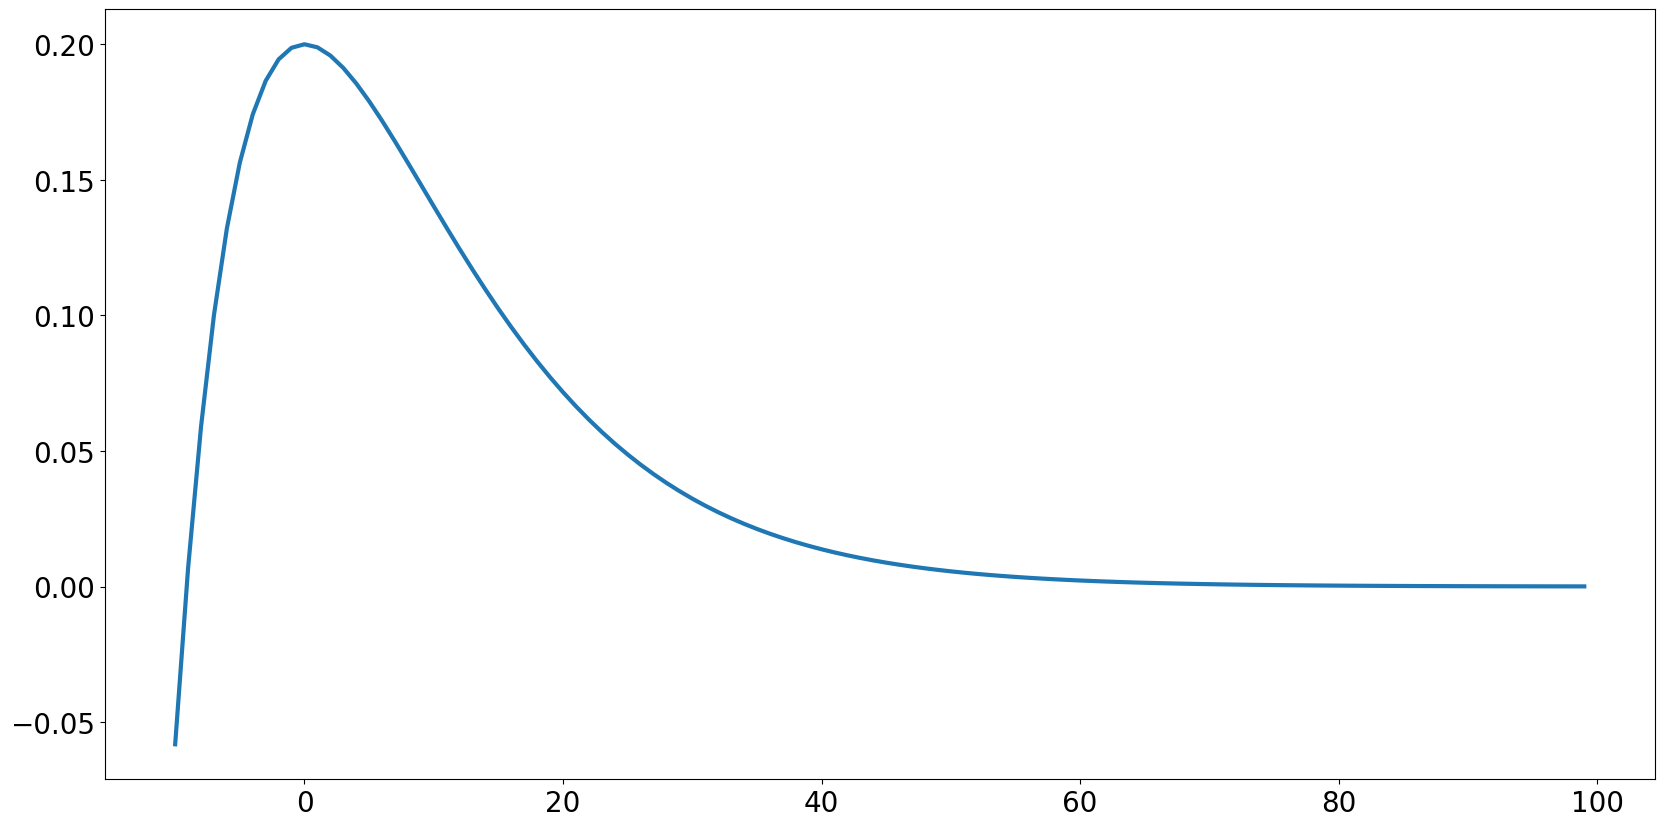

In [33]:
plt.plot(deltads, np.exp(-deltads*p_alpha*(1+delta))*(np.exp(deltads/xi)*(1+delta)-1))

In [34]:
p_delta_t1_delta_d1s.shape

(1000, 110)

In [35]:
f'{1/(90/7):.1e}'

'7.8e-02'

In [36]:
import warnings
warnings.filterwarnings('ignore')

max p1t1: 9.1e-05
max p2t2: 1.7e-04
max p3t1d1: 2.8e-04


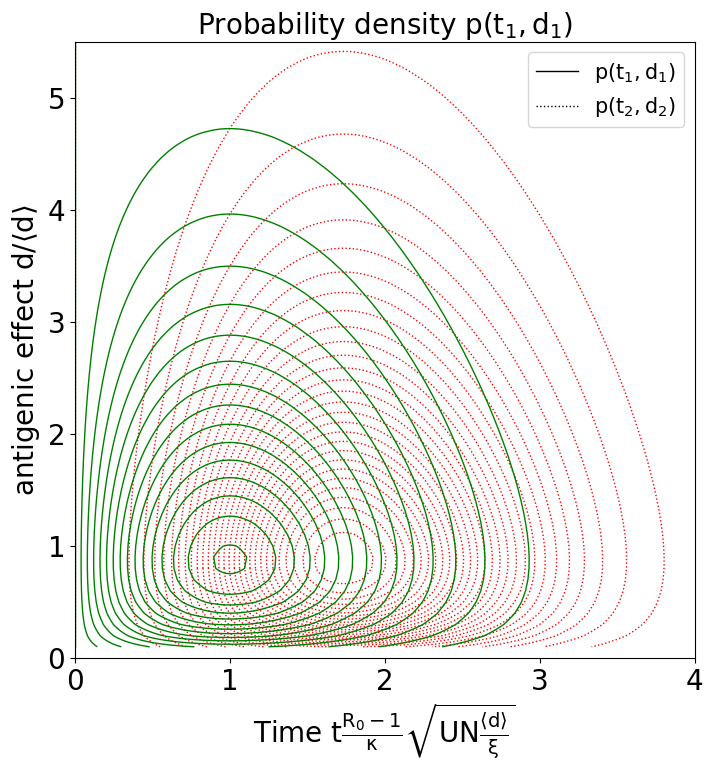

In [41]:
print(f'max p1t1: {np.max(p_t1_d1s):.1e}')
print(f'max p2t2: {np.max(p_t2_d2s):.1e}')
print(f'max p3t1d1: {np.max(p_delta_t1_delta_d1s):.1e}')    
mlevel = np.max([np.max(p_t2_d2s),np.max(p_t1_d1s)])

fig,ax= plt.subplots(1,1,figsize=(8,8))
plt.subplots_adjust(wspace=0.3)

ax.contour(tt*np.sqrt(alpha*delta),dd/dbar,p_t2_d2s,levels=np.linspace(0,mlevel,30),linewidths=1,linestyles=':',label = r'$p(t_2,d_2)$',colors='red')
ax.contour(tt*np.sqrt(alpha*delta),dd/dbar,p_t1_d1s,levels=np.linspace(0,mlevel,30),linewidths=1,label = r'$p(t_1,d_1)$',colors='green')
ax.set_xlabel(r'Time $t \frac{R_0-1}{\kappa} \sqrt{U N  \frac{\langle d \rangle}{\xi}}$',fontsize=20)
ax.set_ylabel(r'antigenic effect $d/\langle d \rangle$',fontsize=20)
handles = [Line2D([0], [0], color='black', linewidth=1, label=r'$p(t_1,d_1)$'),
              Line2D([0], [0], color='black', linewidth=1, linestyle=':',label=r'$p(t_2,d_2)$')]
ax.legend(handles= handles,fontsize=15)
ax.set_title('Probability density $p(t_1,d_1)$', fontsize=20)
ax.set_ylim(0,5.5)
ax.set_xlim(0,4)

# ax[1].contour(deltats*np.sqrt(alpha*delta),deltads/dbar,p_delta_t1_delta_d1s.T,levels=np.linspace(0,2*mlevel,40),linewidths=1,label = r'$p(\Delta t,\Delta d)$')
# ax[1].set_xlabel(r'Time $\Delta t \frac{R_0-1}{\kappa} \sqrt{U N \frac{\langle d \rangle}{\xi}}$',fontsize=20)
# ax[1].set_ylabel(r'antigenic effect diff. $\Delta d/\langle d \rangle$',fontsize=20)
# # ax[1].legend(fontsize=15)
# ax[1].set_title(r'Probability density $p(\Delta t,\Delta d)$', fontsize=20)
# ax[1].set_ylim(-1,2)
# ax[1].set_xlim(0,2)

plt.savefig(output_folder+'contours.svg',bbox_inches='tight')


avg t1: 1.25
avg delta t: 0.62
avg_deltat/avg_t: 0.50


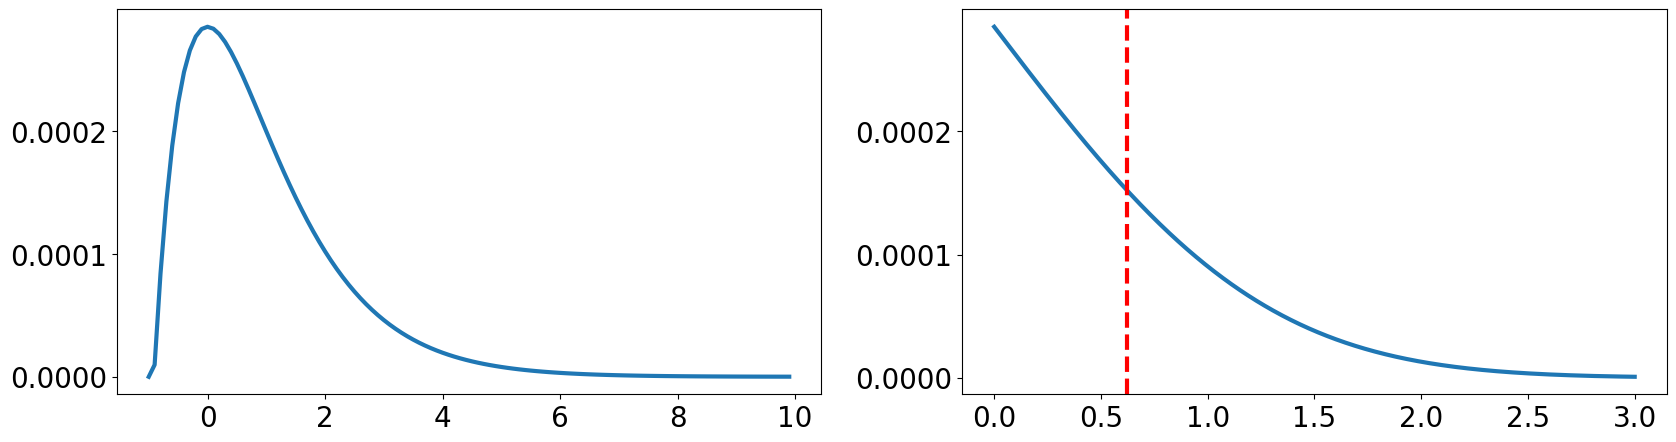

In [38]:
fig,ax= plt.subplots(1,2,figsize=(20,5))

ax[0].plot(deltads/dbar, p_delta_t1_delta_d1s[0,:],label = r'$p(\delta,t_1,\delta_1)$');
ax[1].plot(deltats* np.sqrt(alpha*delta)
           , p_delta_t1_delta_d1s[:,np.argmax(p_delta_t1_delta_d1s[0,:])],label = r'$p(\delta,t_1,\delta_1)$');

avg_t = np.sum(p_t1_d1s*ts.reshape(-1,1)*np.diff(ts)[0])*np.sqrt(alpha*delta)
avg_t/=np.sum(p_t1_d1s*np.diff(ts)[0])
avg_deltat= np.sum(p_delta_t1_delta_d1s*deltats.reshape(-1,1)*np.diff(deltats)[0])*np.sqrt(alpha*delta)
avg_deltat/=np.sum(p_delta_t1_delta_d1s*np.diff(deltats)[0])

print(f'avg t1: {avg_t:.2f}')
print(f'avg delta t: {avg_deltat:.2f}')
print(f'avg_deltat/avg_t: {avg_deltat/avg_t:.2f}')
# ax[0].set_xlim(-1,1)
# ax[1].axvline(avg_t,linestyle='dashed',color='black',label = r'$\langle t_1 \rangle$');
ax[1].axvline(avg_deltat,linestyle='dashed',color='red',label = r'$\langle \delta t_1 \rangle$');

In [39]:
print(np.sum(p_delta_t1_delta_d1s*np.diff(deltats)[0]))

1.3335718114242519


In [40]:
0.5*np.sqrt(np.pi/2)

0.6266570686577501